In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

In [ ]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -q UCMerced_LandUse.zip
!rm UCMerced_LandUse.zip

--2024-12-16 01:08:47--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  25.9MB/s    in 13s     

2024-12-16 01:09:01 (24.2 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
])

In [ ]:
dataset = ImageFolder(root='./UCMerced_LandUse/Images', transform=transform)

In [ ]:
class FourierConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, image_size):
        super(FourierConvLayer, self).__init__()
        self.image_size = image_size
        self.real = nn.Parameter(torch.empty(out_channels, in_channels, image_size, image_size))
        self.imag = nn.Parameter(torch.empty(out_channels, in_channels, image_size, image_size))
        nn.init.xavier_uniform_(self.real)
        nn.init.xavier_uniform_(self.imag)

    def forward(self, x):
        x_fft = torch.fft.fft2(x, dim=(-2, -1))
        kernel_fft = torch.complex(self.real, self.imag).unsqueeze(0)
        output_fft = (x_fft.unsqueeze(1) * kernel_fft).sum(dim=2)
        output = torch.fft.ifft2(output_fft, dim=(-2, -1)).real
        return output

In [ ]:
class FourierPoolingLayer(nn.Module):
    def __init__(self, pool_size):
        super(FourierPoolingLayer, self).__init__()
        self.pool_size = pool_size

    def forward(self, x):
        h, w = x.shape[-2], x.shape[-1]
        y_min, y_max = int(h / 2 - self.pool_size / 2), int(h / 2 + self.pool_size / 2)
        x_min, x_max = int(w / 2 - self.pool_size / 2), int(w / 2 + self.pool_size / 2)
        return x[..., y_min:y_max, x_min:x_max]

In [ ]:
class FourierCNN(nn.Module):
    def __init__(self, image_size=224, num_classes=21):
        super(FourierCNN, self).__init__()
        self.fourier_conv1 = FourierConvLayer(3, 8, kernel_size=3, image_size=image_size)
        self.pool1 = FourierPoolingLayer(pool_size=image_size // 2)
        image_size //= 2
        self.fourier_conv2 = FourierConvLayer(8, 16, kernel_size=3, image_size=image_size)
        self.pool2 = FourierPoolingLayer(pool_size=image_size // 2)
        reduced_size = image_size // 2
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * reduced_size * reduced_size, 256)
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.fourier_conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.fourier_conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
temp_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
mean, std = [0.0]*3, [0.0]*3
for images, _ in temp_loader:
  for i in range(3):
    mean[i] += images[:, i, :, :].mean().item()
    std[i] += images[:, i, :, :].std().item()

mean = [m / len(temp_loader) for m in mean]
std = [s / len(temp_loader) for s in std]

print(f"Computed mean: {mean}, std: {std}")

Computed mean: [0.48161879032850263, 0.4874905899167061, 0.44926644712686536], std: [0.21318163052201272, 0.1965382605791092, 0.1910616524517536]


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(10, shear=10),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

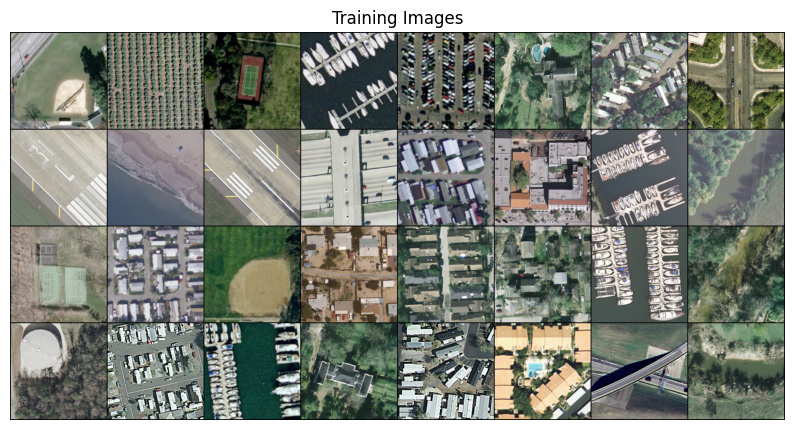

In [ ]:
# Visualize some training images
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Undo normalization for visualization
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)
images = inv_normalize(images)

# Plot images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(vutils.make_grid(images, nrow=8, padding=2).permute(1, 2, 0))
plt.show()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FourierCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return epoch_loss / len(loader), correct / total

def validate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return epoch_loss / len(loader), correct / total

# Training loop
epochs = 20
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

# Step 6: Test evaluation
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss={test_loss:.4f}, Test Accuracy={test_acc:.4f}")

Epoch 1/20: Train Loss=3.0021, Train Acc=0.0730, Val Loss=2.9624, Val Acc=0.0690
Epoch 2/20: Train Loss=2.8673, Train Acc=0.1135, Val Loss=2.8955, Val Acc=0.1095
Epoch 3/20: Train Loss=2.6796, Train Acc=0.1817, Val Loss=2.7822, Val Acc=0.1714
Epoch 4/20: Train Loss=2.3207, Train Acc=0.3040, Val Loss=2.6700, Val Acc=0.1905
Epoch 5/20: Train Loss=1.8341, Train Acc=0.4270, Val Loss=2.6012, Val Acc=0.2548
Epoch 6/20: Train Loss=1.3265, Train Acc=0.6024, Val Loss=2.5999, Val Acc=0.2714
Epoch 7/20: Train Loss=0.9156, Train Acc=0.7302, Val Loss=2.9396, Val Acc=0.2357
Epoch 8/20: Train Loss=0.6012, Train Acc=0.8413, Val Loss=3.0049, Val Acc=0.2405
Epoch 9/20: Train Loss=0.4489, Train Acc=0.8825, Val Loss=3.2497, Val Acc=0.2595
Epoch 10/20: Train Loss=0.3476, Train Acc=0.9190, Val Loss=3.2536, Val Acc=0.2714
Epoch 11/20: Train Loss=0.2470, Train Acc=0.9548, Val Loss=3.5184, Val Acc=0.2643
Epoch 12/20: Train Loss=0.1565, Train Acc=0.9722, Val Loss=3.5841, Val Acc=0.2643
Epoch 13/20: Train Loss=0

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FourierCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

In [ ]:
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

epochs = 30

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
      epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
      print("Early stopping!")
      break

    scheduler.step(avg_val_loss)

model.load_state_dict(torch.load('best_model.pth'))

model.eval()
test_loss=0
correct=0
total=0

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs=model(inputs)
    loss=criterion(outputs, labels)
    test_loss+=loss.item()
    _, predicted = torch.max(outputs,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total * 100

print(f"Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}%")

Epoch 1, Train Loss: 3.0111513590510888, Val Loss: 2.9563083383772106
Epoch 2, Train Loss: 2.91128948066808, Val Loss: 2.871397336324056
Epoch 3, Train Loss: 2.832578480998172, Val Loss: 2.812352118668733
Epoch 4, Train Loss: 2.7069205694560763, Val Loss: 2.7319577976509377
Epoch 5, Train Loss: 2.4952501556541344, Val Loss: 2.603919015990363
Epoch 6, Train Loss: 2.1894517940810965, Val Loss: 2.6001290965963295
Epoch 7, Train Loss: 1.831824381140214, Val Loss: 2.589847277711939
Epoch 8, Train Loss: 1.5138838547694533, Val Loss: 2.7076656332722417
Epoch 9, Train Loss: 1.2337983929658238, Val Loss: 2.874423958637096
Epoch 10, Train Loss: 0.9807841234569308, Val Loss: 3.098312090944361
Epoch 11, Train Loss: 0.7601793898811823, Val Loss: 3.0331977429213346
Epoch 12, Train Loss: 0.6883939942227134, Val Loss: 3.084420998891195
Early stopping!
Test Loss: 2.7097237551653826, Test Accuracy: 20.714285714285715%


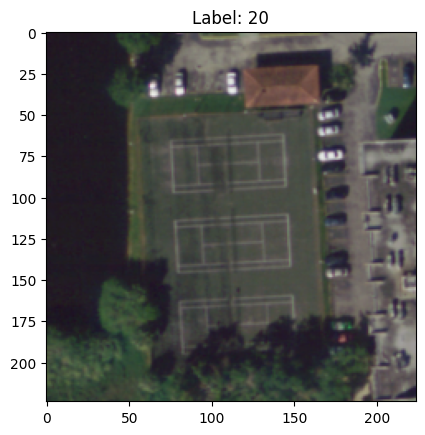

In [ ]:
# Get the image and label at a specific index (e.g., index 0)
index = 0
image, label = val_dataset.dataset[val_dataset.indices[index]]


inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)
image = inv_normalize(image)  # Un-normalize

plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for display
plt.title(f"Label: {label}")
plt.show()

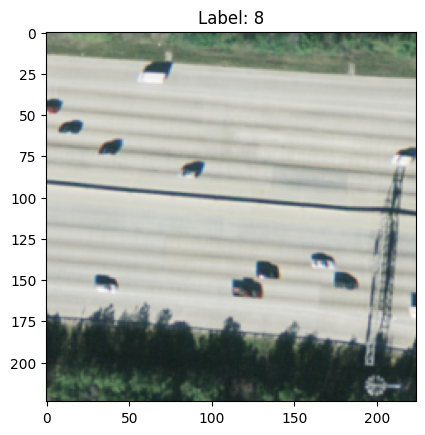

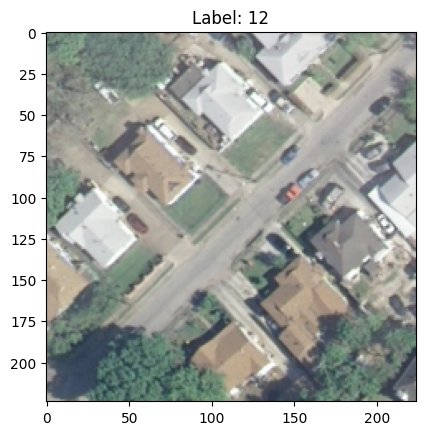

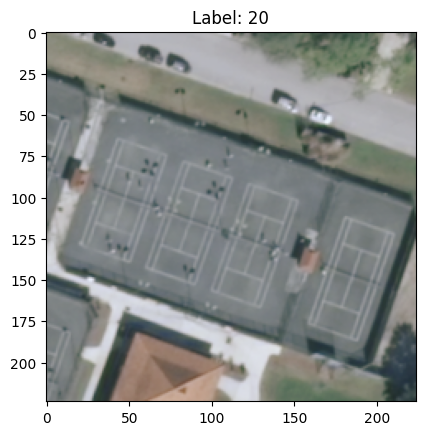

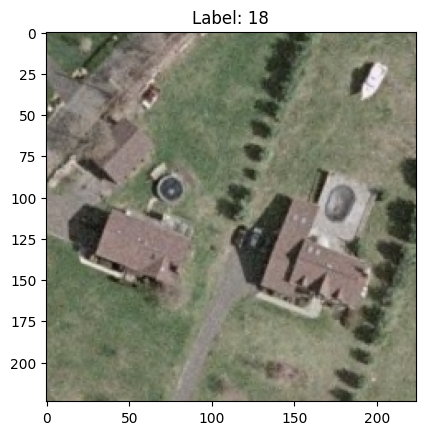

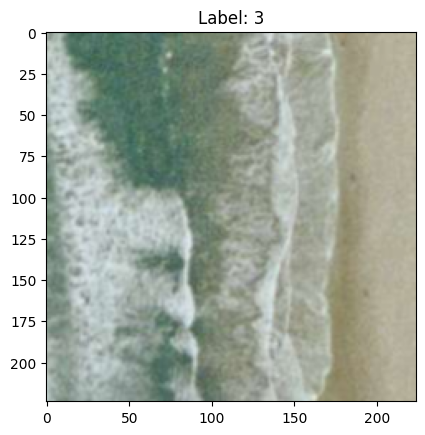

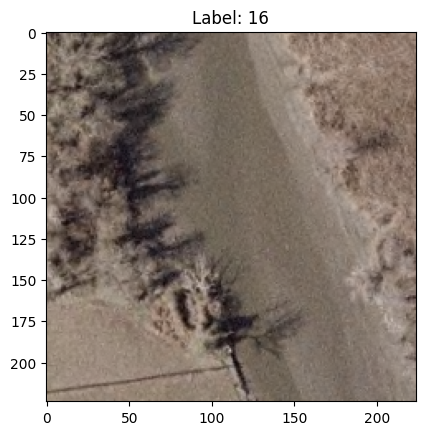

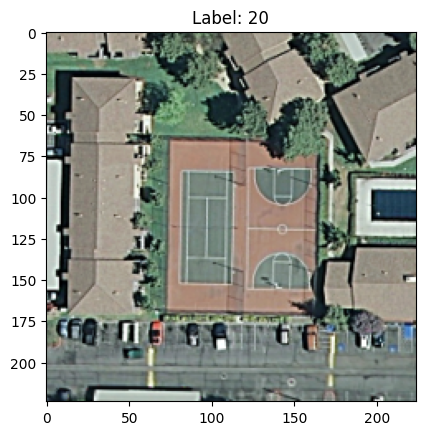

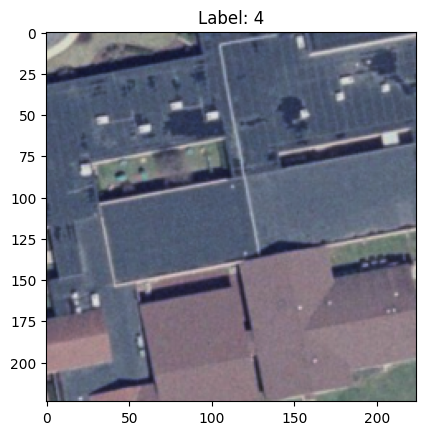

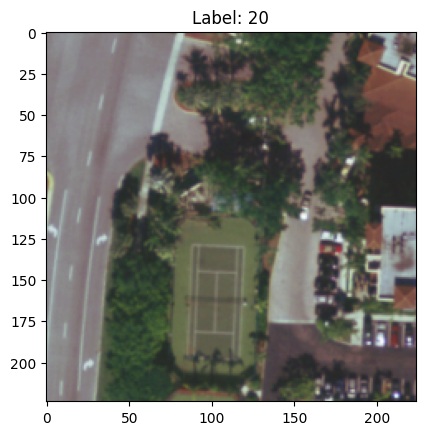

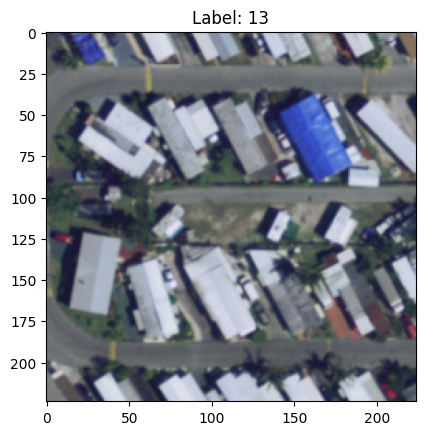

In [ ]:
import numpy as np
# Get the image and label at a specific index (e.g., index 0)
indices = np.arange(0,10)
for index in indices:
  image, label = test_dataset.dataset[test_dataset.indices[index]]

  inv_normalize = transforms.Normalize(
      mean=[-m / s for m, s in zip(mean, std)],
      std=[1 / s for s in std]
  )
  image = inv_normalize(image)  # Un-normalize

  plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for display
  plt.title(f"Label: {label}")
  plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FourierCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training Loop
num_epochs = 5
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, val_losses, val_accuracies = [], [], []

best_val_loss = float("inf")
patience = 5
trigger_count = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_count = 0  # Reset patience counter
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        trigger_count += 1
        if trigger_count >= patience:
            print("Early stopping!")
            break

Epoch 1, Train Loss: 1.0681, Val Loss: 0.0000
Epoch 2, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 3, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 4, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 5, Train Loss: 0.0000, Val Loss: 0.0000


In [ ]:
# Evaluate on hold-out test set
model.load_state_dict(torch.load("best_model.pth"))  # Load the best model
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_accuracy = 100.0 * correct / total
print(f"Hold-Out Test Accuracy: {test_accuracy:.2f}%")